<a href="https://colab.research.google.com/github/thdgmltjd123/Assignment01/blob/master/Assignment11_20150711.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브와 코랩 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***Computation Area***

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import numpy as np
import pandas as pd
import math

In [3]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.1307,),(0.3081,)),
])

In [62]:
# 부모클래스 nn.Module로부터 상속받는 자식클래스 classification
class MyModel(nn.Module):
  def __init__(self, num_classes = 10, size_kernel = 3):
    # 부모클래스의 생성자를 이용하겠다.
    super(MyModel, self).__init__()

    self.number_class   = num_classes
    self.size_kernel    = size_kernel

    # feature layer
    # Convolutional Layer <-- Input으로 부터 특징을 추출하는 층들
    self.convolutional0 = nn.Sequential(
        nn.Conv2d(1,16,size_kernel, padding = 1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2),
    )
    self.convolutional1 = nn.Sequential(
        nn.Conv2d(16,32,size_kernel, padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
    )
    self.convolutional2 = nn.Sequential(
        nn.Conv2d(32,64,size_kernel, padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
    )
    self.convolutional3 = nn.Sequential(
        nn.Conv2d(64,128,size_kernel, padding = 1, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )
    self.feature = nn.Sequential(self.convolutional0,
                                 self.convolutional1,
                                 self.convolutional2,
                                 self.convolutional3)

    # layer 1층 : 28*28 데이터가 600으로 나옴
    # activation_function = ReLU
    self.classifier1 = nn.Sequential(
        nn.Linear(in_features = 128*5*5, out_features=600, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.6),
    )
    # layer 2층 : 600 데이터가 300으로 나옴
    # activation_function = ReLU
    self.classifier2 = nn.Sequential(
        nn.Linear(in_features = 600, out_features = 300, bias = True),
        nn.ReLU(),
        nn.Dropout(p = 0.6)
    )
    # output layer 3층 : 300 데이터가 10으로 나옴
    self.classifier3 = nn.Sequential(
        nn.Linear(in_features=300, out_features = num_classes, bias = True),
    )
    self.classifier = nn.Sequential(self.classifier1, self.classifier2,self.classifier3)
    self._initialize_weight()

  def _initialize_weight(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
        if m.bias is not None:
          m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=math.sqrt(2))
        if m.bias is not None:
          m.bias.data.zero_()

  # 순전파 알고리즘
  def forward(self, inputs):
    x = self.feature(inputs)
    x = x.view(x.size(0),-1)
    x = self.classifier(x)
    return x

In [75]:
# Convolutional Neural Network using Pytorch
def CNN(train_loader, test_loader, epoch, learning_rate, no_cuda = False):
  use_cuda = not no_cuda and torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  Model = MyModel().to(device)
  optimizer = torch.optim.AdamW(Model.parameters(), lr = learning_rate)
  train_L_iters = []
  train_acc_iters = []
  test_L_iters = []
  test_acc_iters = []
  for i in range(1,epoch+1):
    # Train mode
    train_loss = 0
    train_correct = 0
    Model.train()
    for batch_idx,(data, target) in enumerate(train_loader):
      # data와 target을 gpu를 사용할 수 있게 매핑
      data, target = data.to(device), target.to(device)
      # backward하는 과정에서 기존의 gradient값에 새로운 gradient 값을
      # 더해주기때문에 grad값을 매 backward마다 0으로 초기화해줘야 올바른 학습이 가능
      optimizer.zero_grad()
      # 순전파
      output = Model(data)
      # reduction = (default) "mean"
      loss = F.cross_entropy(output,target)
      train_loss += F.cross_entropy(output,target,reduction = 'sum').item()
      pred = output.argmax(dim = 1, keepdim = True)
      train_correct += pred.eq(target.view_as(pred)).sum().item()
      # 역전파
      loss.backward()
      optimizer.step()
    # 에포크별 평균 트레인 로스 계산
    train_loss /= len(train_loader.dataset)
    train_L_iters.append(train_loss)
    # 에포크별 평균 정확도 계산
    accuracy =  100 * train_correct / len(train_loader.dataset)
    train_acc_iters.append(accuracy)    
    # torch.no_grad() 테스트 할 때, 위에서 계산한 grad를 더이상 업데이트 하지 않음.
    with torch.no_grad():
      Model.eval()
      test_loss = 0
      test_correct = 0
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = Model(data)
        test_loss += F.cross_entropy(output, target, reduction = 'sum').item()
        pred = output.argmax(dim = 1, keepdim = True)
        test_correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_L_iters.append(test_loss)
    accuracy = 100 * test_correct / len(test_loader.dataset)
    test_acc_iters.append(accuracy)
    if i % 10 == 0:
      print("progress = {}, current loss = {}, current device = {}".format(100 * i / epoch, train_loss, torch.cuda.get_device_name()))
      print("test loss = {} test accuracy = {}\n".format(test_loss, accuracy))

  return train_L_iters, train_acc_iters, test_L_iters, test_acc_iters
    

In [76]:
data_path = '/content/drive/My Drive/Colab Notebooks'
temp_train = datasets.MNIST(root = data_path, train = False, 
                  download=True, transform = transform)
temp_test = datasets.MNIST(root = data_path, train = True, 
                  download=True, transform = transform)

In [78]:
# 배치사이즈별 학습
bs = 1000
epoch = 100
learning_rate_value = 0.005
no_cuda = False
# 배치사이즈별 loss and accuracy
batch_train_loss = []
batch_test_loss = []
batch_train_accuracy = []
batch_test_accuracy = []
data_path = '/content/drive/My Drive/Colab Notebooks'
# 배치사이즈별 학습
print("batch_size  = {}".format(bs))
train_loader = torch.utils.data.DataLoader(
                  temp_train,
                  batch_size = bs,
                  shuffle = False)
test_loader = torch.utils.data.DataLoader(
                  temp_test,
                  batch_size = 60000,
                  shuffle = False)
train_L_iters, train_acc_iters,test_L_iters, test_acc_iters = CNN(train_loader, test_loader,epoch, learning_rate_value)
batch_train_loss.append(train_L_iters)
batch_train_accuracy.append(train_acc_iters)
batch_test_loss.append(test_L_iters)
batch_test_accuracy.append(test_acc_iters)

batch_size  = 1000
progress = 10.0, current loss = 0.23189721069335936, current device = Tesla T4
test loss = 0.14413982747395834 test accuracy = 96.49166666666666

progress = 20.0, current loss = 0.11627525482177735, current device = Tesla T4
test loss = 0.107942724609375 test accuracy = 97.54

progress = 30.0, current loss = 0.06898960456848144, current device = Tesla T4
test loss = 0.114737158203125 test accuracy = 97.62166666666667

progress = 40.0, current loss = 0.06148331394195557, current device = Tesla T4
test loss = 0.09456292317708333 test accuracy = 97.89166666666667

progress = 50.0, current loss = 0.04546770401000977, current device = Tesla T4
test loss = 0.1076025634765625 test accuracy = 97.71666666666667

progress = 60.0, current loss = 0.04739931602478027, current device = Tesla T4
test loss = 0.10535048828125 test accuracy = 97.86666666666666

progress = 70.0, current loss = 0.02704034471511841, current device = Tesla T4
test loss = 0.08533854166666667 test accuracy 

In [79]:
print(max(batch_test_accuracy[0]))
print(min(batch_test_loss[0]))
print(batch_test_accuracy[0][-1])
print(batch_test_loss[0][-1])

98.455
0.0812736083984375
98.14333333333333
0.094925341796875


# ***Output Area***

# **[Output] Plot the Training and testing losses with a batch size of 16**

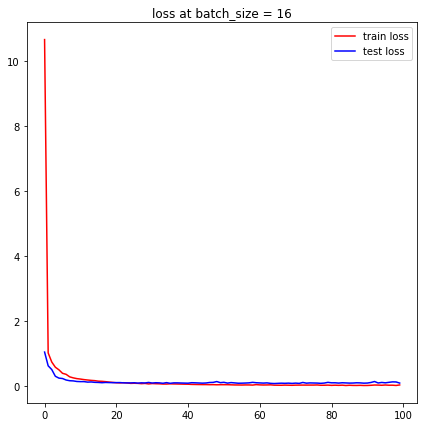

In [80]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_loss[0], c = "red", label = "train loss")
plt.plot(batch_test_loss[0], c = "blue", label = "test loss")
plt.title("loss at batch_size = 16")
plt.legend(loc = "best")
plt.show()

# **[Output] Plot the training and testing accuracies with a batch size of 16**

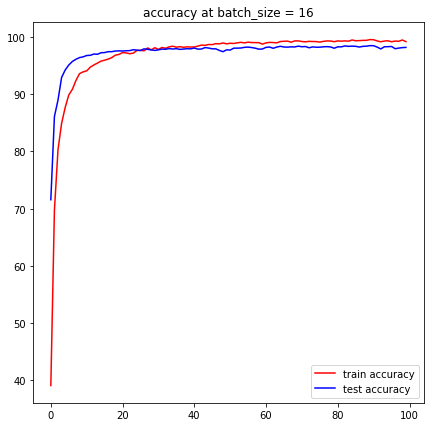

In [81]:
plt.figure(figsize = (7,7))
plt.plot(batch_train_accuracy[0], c = "red", label = "train accuracy")
plt.plot(batch_test_accuracy[0], c = "blue", label = "test accuracy")
plt.title("accuracy at batch_size = 16")
plt.legend(loc = "best")
plt.show()

# **[Output] Print the loss at convergence with different mini-batch sizes**

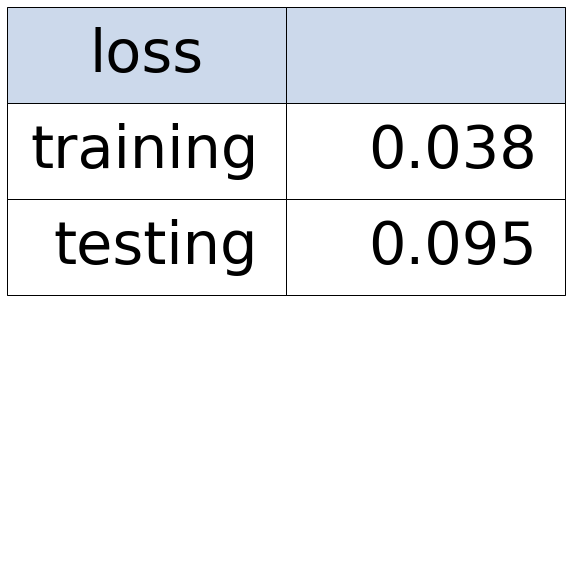

In [82]:
columns = ["loss"," "]
cellText = [["training", round(batch_train_loss[0][-1],3)],
            ["testing", round(batch_test_loss[0][-1],3)]]
colors = ["#ccd9eb","#ccd9eb"]
fig, ax = plt.subplots(figsize = (5,5))
plt.axis("off")
table = ax.table(cellText = cellText,
                 colLabels = columns,
                 colColours = colors,
                 loc = "top",
                 )
table.set_fontsize(100)
table.scale(2,8)

# **[Output] Print the accuracy at convergence with different mini-batch sizes**

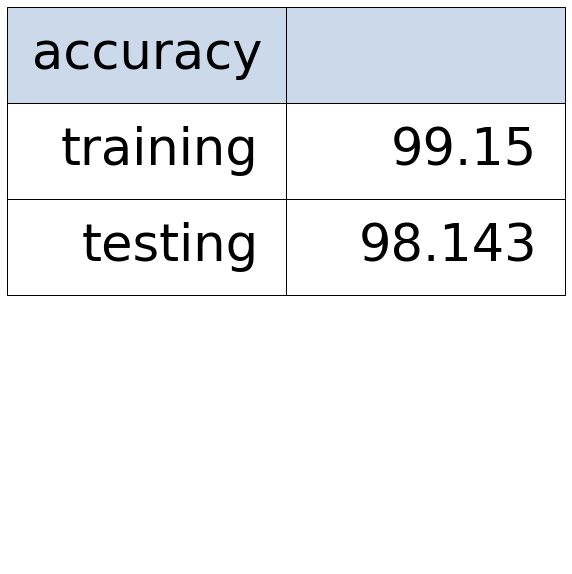

In [83]:
columns = ["accuracy"," "]
cellText = [["training", round(batch_train_accuracy[0][-1],3)],
            ["testing", round(batch_test_accuracy[0][-1],3)]]
colors = ["#ccd9eb","#ccd9eb"]
fig, ax = plt.subplots(figsize = (5,5))
plt.axis("off")
table = ax.table(cellText = cellText,
                 colLabels = columns,
                 colColours = colors,
                 loc = "top"
                 )
table.set_fontsize(100)
table.scale(2,8)